In [3]:
!pip install pandas matplotlib scikit-learn transformers torch seaborn


# PHASE - **1** **bold text**

Jupyter Notebook Validation Tool
--------------------------------
Please upload your Jupyter Notebook:


Saving the-next-billionaire.ipynb to the-next-billionaire.ipynb


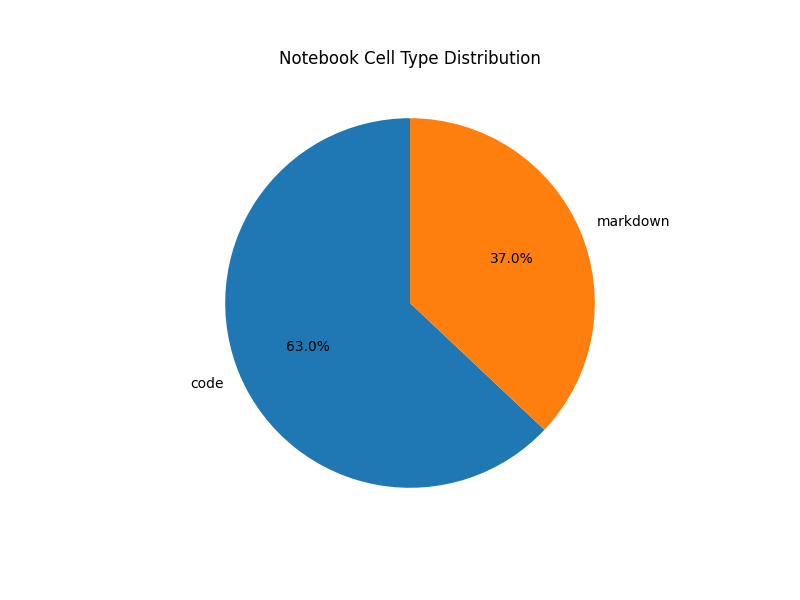

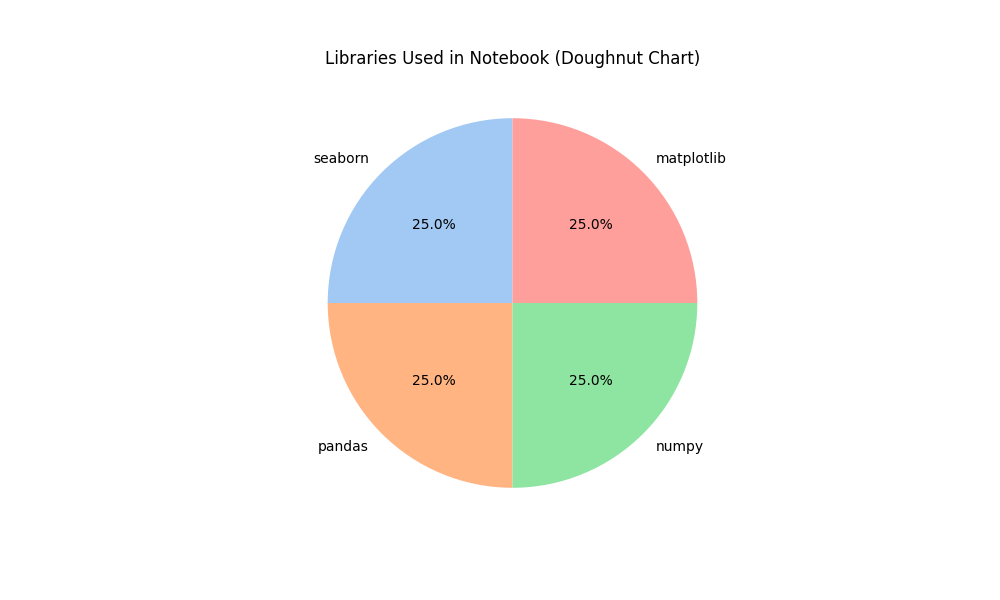

In [6]:
import os
import nbformat
import pandas as pd
import json
import ast
import textwrap
from io import BytesIO
from google.colab import files
from IPython.display import display, HTML, Image
import matplotlib.pyplot as plt
import seaborn as sns


class NotebookValidator:
    def __init__(self):
        self.dataframes = []
        self.code_stats = {
            'total_cells': 0,
            'code_cells': 0,
            'markdown_cells': 0,
            'libraries': set()
        }

    def extract_dataframes(self, notebook):
        self.dataframes = []
        self.code_stats = {
            'total_cells': len(notebook.cells),
            'code_cells': 0,
            'markdown_cells': 0,
            'libraries': set()
        }

        for cell in notebook.cells:
            if cell.cell_type == 'code':
                self.code_stats['code_cells'] += 1
                self._check_library_imports(cell.source)
                try:
                    self._extract_dataframes_from_cell(cell.source)
                except Exception as e:
                    print(f"Error processing cell: {e}")

        return self.dataframes

    def _check_library_imports(self, cell_source):
        common_data_libs = [
            'pandas', 'numpy', 'matplotlib', 'seaborn',
            'scikit-learn', 'scipy', 'plotly', 'sklearn'
        ]
        for lib in common_data_libs:
            if lib in cell_source:
                self.code_stats['libraries'].add(lib)

    def _extract_dataframes_from_cell(self, cell_source):
        try:
            tree = ast.parse(cell_source)
            for node in ast.walk(tree):
                if isinstance(node, ast.Assign):
                    try:
                        source_lines = textwrap.dedent(cell_source)
                        local_vars = {}
                        exec(source_lines, {}, local_vars)
                        for var_name, var_value in local_vars.items():
                            if isinstance(var_value, pd.DataFrame):
                                self.dataframes.append(var_value)
                    except Exception:
                        pass
        except Exception:
            pass

    def validate_notebook(self, notebook_path):
        try:
            with open(notebook_path, 'r', encoding='utf-8') as f:
                notebook = nbformat.read(f, as_version=4)
            dataframes = self.extract_dataframes(notebook)
            validation_results = {
                'notebook_stats': {
                    'total_cells': self.code_stats['total_cells'],
                    'code_cells': self.code_stats['code_cells'],
                    'markdown_cells': self.code_stats['total_cells'] - self.code_stats['code_cells'],
                    'libraries_used': list(self.code_stats['libraries'])
                },
                'dataframes': []
            }
            for i, df in enumerate(dataframes, 1):
                df_analysis = self._analyze_dataframe(df, f"DataFrame_{i}")
                validation_results['dataframes'].append(df_analysis)
            validation_results['visualizations'] = self._generate_notebook_visualizations(notebook)
            return validation_results
        except Exception as e:
            return {
                'error': f'Notebook validation failed: {str(e)}',
                'details': str(e)
            }

    def _analyze_dataframe(self, df, df_name):
        structural_complexity = self._analyze_structural_complexity(df)
        data_quality = self._analyze_data_quality(df)
        return {
            'name': df_name,
            'shape': {
                'rows': df.shape[0],
                'columns': df.shape[1]
            },
            'column_types': dict(df.dtypes),
            'missing_values': df.isnull().sum().to_dict(),
            'duplicate_rows': df.duplicated().sum(),
            'unique_values_per_column': {col: df[col].nunique() for col in df.columns},
            'structural_complexity': structural_complexity,
            'data_quality': data_quality
        }

    def _analyze_structural_complexity(self, df):
        type_diversity = len(set(df.dtypes))
        correlation_matrix = df.corr()
        return {
            'type_diversity': type_diversity,
            'correlation_matrix': correlation_matrix.to_dict()
        }

    def _analyze_data_quality(self, df):
        completeness = df.isnull().mean().mean()
        unique_records_ratio = 1 - (df.duplicated().mean())
        numeric_consistency = df.select_dtypes(include='number').apply(lambda x: x.dropna().mean())
        return {
            'completeness': completeness,
            'unique_records_ratio': unique_records_ratio,
            'numeric_consistency': numeric_consistency.to_dict()
        }

    def _generate_notebook_visualizations(self, notebook):
        os.makedirs('notebook_validation_output', exist_ok=True)
        visualizations = {}

        plt.figure(figsize=(8, 6))
        cell_types = ['code', 'markdown']
        cell_counts = [
            sum(1 for cell in notebook.cells if cell.cell_type == 'code'),
            sum(1 for cell in notebook.cells if cell.cell_type == 'markdown')
        ]
        plt.pie(cell_counts, labels=cell_types, autopct='%1.1f%%', startangle=90, colors=['#1f77b4', '#ff7f0e'])
        plt.title('Notebook Cell Type Distribution')
        viz_path = 'notebook_validation_output/cell_type_distribution.png'
        plt.savefig(viz_path)
        plt.close()
        visualizations['cell_type_distribution'] = viz_path

        plt.figure(figsize=(10, 6))
        library_usage_count = {lib: 0 for lib in self.code_stats['libraries']}

        for cell in notebook.cells:
            if cell.cell_type == 'code':
                for lib in self.code_stats['libraries']:
                    if lib in cell.source:
                        library_usage_count[lib] += 1

        total_usage = sum(library_usage_count.values())
        lib_percentages = [count / total_usage * 100 for count in library_usage_count.values()]

        plt.pie(lib_percentages, labels=self.code_stats['libraries'], autopct='%1.1f%%', startangle=90, colors=sns.color_palette('pastel'))
        plt.title('Libraries Used in Notebook (Doughnut Chart)')
        viz_path = 'notebook_validation_output/libraries_used_doughnut.png'
        plt.savefig(viz_path)
        plt.close()
        visualizations['libraries_used_doughnut'] = viz_path

        return visualizations

def main():
    print("Jupyter Notebook Validation Tool")
    print("--------------------------------")
    print("Please upload your Jupyter Notebook:")
    uploaded_files = files.upload()

    validator = NotebookValidator()
    results = []

    for filename, file_content in uploaded_files.items():
        notebook_content = file_content.decode('utf-8')
        notebook = nbformat.reads(notebook_content, as_version=4)
        temp_notebook_path = f'/content/{filename}'
        with open(temp_notebook_path, 'w', encoding='utf-8') as f:
            f.write(notebook_content)
        result = validator.validate_notebook(temp_notebook_path)
        os.remove(temp_notebook_path)
        html_content = f"<h2>Validation Results for {filename}</h2>"
        html_content += "<pre>" + json.dumps(result, indent=2) + "</pre>"
        if 'visualizations' in result:
            for viz_name, viz_path in result['visualizations'].items():
                html_content += f"<h3>{viz_name.replace('_', ' ').title()}</h3>"
                html_content += f"<img src='{viz_path}' width='600'>"
                display(HTML(f"<h3>{viz_name.replace('_', ' ').title()}</h3>"))
                display(Image(filename=viz_path))
        display(HTML(html_content))
        results.append(result)

    return results

if __name__ == "__main__":
    main()


### **PHASE - 2**

In [7]:
import os
import nbformat
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from google.colab import files, output
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import torch

# Load the Hugging Face model and tokenizer for feedback generation
model_name = "google/flan-t5-large"
tokenizer = AutoTokenizer.from_pretrained(model_name)
hf_model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

# Function to extract features from Jupyter notebooks
def extract_features(notebook_path):
    with open(notebook_path, 'r', encoding='utf-8') as f:
        notebook_content = nbformat.read(f, as_version=4)

    num_code_cells = 0
    num_markdown_cells = 0
    libraries_used = set()
    code_cell_lengths = []

    for cell in notebook_content.cells:
        if cell.cell_type == 'code':
            num_code_cells += 1
            code_cell_lengths.append(len(cell.source.split()))
            # Detect libraries from import statements
            for lib in ['pandas', 'numpy', 'matplotlib', 'seaborn', 'plotly']:
                if lib in cell.source:
                    libraries_used.add(lib)
        elif cell.cell_type == 'markdown':
            num_markdown_cells += 1

    return {
        'num_code_cells': num_code_cells,
        'num_markdown_cells': num_markdown_cells,
        'num_libraries': len(libraries_used),
        'avg_code_length': sum(code_cell_lengths) / len(code_cell_lengths) if code_cell_lengths else 0
    }

# Load and preprocess dataset
def load_dataset(csv_path):
    dataset = pd.read_csv(csv_path)
    features = dataset.drop(columns=["complexity_label"])
    labels = dataset["complexity_label"]
    return features, labels

# Train a model
def train_model(features, labels):
    label_encoder = LabelEncoder()
    encoded_labels = label_encoder.fit_transform(labels)
    # Modify the test_size to a smaller value if you have limited data
    X_train, X_test, y_train, y_test = train_test_split(features, encoded_labels, test_size=0.1, random_state=42)

    model = RandomForestClassifier(random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Model Training Accuracy: {accuracy * 100:.2f}%")

    return model, label_encoder

# Function to predict complexity of a new notebook
def predict_complexity(model, label_encoder, notebook_path):
    features = extract_features(notebook_path)
    features_df = pd.DataFrame([features])
    prediction = model.predict(features_df)
    complexity_label = label_encoder.inverse_transform(prediction)[0]
    return complexity_label, features

# Function to generate tailored feedback using Hugging Face model
def generate_feedback(features, complexity_label):
    prompt = (
        f"The notebook has {features['num_code_cells']} code cells, {features['num_markdown_cells']} markdown cells, "
        f"uses {features['num_libraries']} libraries, and has an average code length of {features['avg_code_length']:.2f} words per cell. "
        f"The complexity level is predicted as '{complexity_label}'. Provide specific recommendations to improve this notebook."
    )

    inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=512)
    outputs = hf_model.generate(**inputs, max_length=512, num_beams=5, early_stopping=True)
    feedback = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return feedback

# Load dataset and train the model
dataset_path = "labeled_notebooks.csv"
features, labels = load_dataset(dataset_path)
model, label_encoder = train_model(features, labels)

# Upload a new notebook for validation
uploaded_notebook = files.upload()
notebook_path = list(uploaded_notebook.keys())[0]

# Predict complexity
predicted_label, extracted_features = predict_complexity(model, label_encoder, notebook_path)
print(f"Predicted Complexity: {predicted_label}")

# Generate and display feedback
feedback = generate_feedback(extracted_features, predicted_label)
print("\nRecommendations:")
print(feedback)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.13G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Model Training Accuracy: 100.00%


Saving music-education-performance-analysis-notebook.ipynb to music-education-performance-analysis-notebook.ipynb
Predicted Complexity: High

Recommendations:
The notebook should have more code cells and fewer markdown cells.
